In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [2]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**One-hot encoding**

In [3]:
 def one_hot_encode(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['gender'], prefix='gender')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

    df = df.drop(columns=['workclass', 'gender', 'fnlwgt', 'education', 'occupation', \
                      'relationship', 'marital', 'race', 'country', 'capgain', \
                      'caploss'])
    return df

# one-hot encoding (for regression mdoels)
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender_Female'=1
# privileged: 'gender_Male'=1

**Parametric Model**

In [5]:
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

# size=1000
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute statistical parity difference**

In [6]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender_Female']==1].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender_Male']==1].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**First-order derivative of loss function at z with respect to model parameters**

(Pre-computed for all training points)

In [9]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

(Pre-computed for all training points)

In [10]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i+1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [11]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [12]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numProtected = X_test_orig['gender_Female'].sum()
    numPrivileged = X_test_orig['gender_Male'].sum()
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['gender_Male'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['gender_Female'] == 1:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [13]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [14]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Second-order Influence function computation**

(For any group of points U)

In [15]:
def second_order_influence(X_train, v1, U, size, del_L_del_theta, hessian_all_points):
    u = len(U) 
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(v1)
    
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_all = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
#         if (i%1000==0):
#             print(i)
        del_L_del_theta_hinv = np.add(del_L_del_theta_hinv, hessian_vector_product(num_params, s, size, del_L_del_theta[idx], hessian_all_points))
        hessian_all = np.add(hessian_all, hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    term1 = c1 * del_L_del_theta_sum
    term2 = c2 * np.dot(hessian_all, del_L_del_theta_hinv)

    I = np.dot(v1.transpose(), (term1 + term2))
    return I

**Determining k for particular drops in log-loss**

In [19]:
# removing k data points that have the max. influence on bias
# identified k for which 10% drop in log-loss, 20% drop, 30% drop
def accuracy_fairness_k(X_train, y_train, X_test, y_test, X_test_orig):
    remove_idx = []
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)
    loss_0 = logistic_loss(y_test, y_pred)
    print(spd_0)
    print(loss_0)
    for k in range(len(sort_index)):
        print(k)
        remove_idx.append(sort_index[k])
        X_removed = np.delete(X_train, remove_idx, 0)
        y_removed = y_train.drop(index=remove_idx, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_k = (computeFairness(y_pred, X_test_orig) - spd_0)/spd_0
        delta_loss_k = (logistic_loss(y_test, y_pred) - loss_0)/loss_0
        print("Loss fraction: ", delta_loss_k)
        print("Spd fraction: ", delta_spd_k)    

accuracy_fairness_k(X_train, y_train, X_test, y_test, X_test_orig)

-0.20059371090978573
0.360972684923813
0
Loss fraction:  0.002565293608663658
Spd fraction:  -0.0008108503392545257
1
Loss fraction:  0.0026679348810044307
Spd fraction:  -0.0012780590475225402
2
Loss fraction:  0.0026764161224010936
Spd fraction:  -0.0017619151959095472
3
Loss fraction:  0.002661620099908332
Spd fraction:  -0.002168835700143185
4
Loss fraction:  0.002669600220760317
Spd fraction:  -0.0026501544367761296
5
Loss fraction:  0.0026716827358680612
Spd fraction:  -0.0031300578852972378
6
Loss fraction:  0.0026858318693879623
Spd fraction:  -0.0034783944084144404
7
Loss fraction:  0.0027004085990388733
Spd fraction:  -0.003939819541672199
8
Loss fraction:  0.002711092963733386
Spd fraction:  -0.004398062851621458
9
Loss fraction:  0.0027436534709481476
Spd fraction:  -0.00477703366821688
10
Loss fraction:  0.0027609655926304046
Spd fraction:  -0.0053037018130847515
11
Loss fraction:  0.0027632693694565565
Spd fraction:  -0.005692368919213939
12
Loss fraction:  0.002773563313

Loss fraction:  0.0053359562646106305
Spd fraction:  -0.04497966985035464
107
Loss fraction:  0.005368805587048863
Spd fraction:  -0.04529104571167256
108
Loss fraction:  0.005408155703337994
Spd fraction:  -0.04574002024926578
109
Loss fraction:  0.005449033092704771
Spd fraction:  -0.0461345148562324
110
Loss fraction:  0.005489894294206175
Spd fraction:  -0.0465046447350356
111
Loss fraction:  0.005529438139558604
Spd fraction:  -0.04690252768913556
112
Loss fraction:  0.005578856297962854
Spd fraction:  -0.0472550630039644
113
Loss fraction:  0.005623993560468086
Spd fraction:  -0.0477516149951831
114
Loss fraction:  0.005663215246336552
Spd fraction:  -0.04816489561089531
115
Loss fraction:  0.005704448176110828
Spd fraction:  -0.048593832559188664
116
Loss fraction:  0.005742247159374187
Spd fraction:  -0.0490021331724748
117
Loss fraction:  0.0057866869091119
Spd fraction:  -0.049380488446327045
118
Loss fraction:  0.005827565572321329
Spd fraction:  -0.049780414904539216
119
Lo

Loss fraction:  0.00981000880054639
Spd fraction:  -0.08466466528126484
214
Loss fraction:  0.009819013212536813
Spd fraction:  -0.08488905185533863
215
Loss fraction:  0.009898073398250582
Spd fraction:  -0.08518869594413829
216
Loss fraction:  0.009953164969787036
Spd fraction:  -0.08558178540226043
217
Loss fraction:  0.010019447623641209
Spd fraction:  -0.08585208265905278
218
Loss fraction:  0.0100336243109119
Spd fraction:  -0.08615903274559233
219
Loss fraction:  0.01007872972907703
Spd fraction:  -0.08649781017619287
220
Loss fraction:  0.010140570488074728
Spd fraction:  -0.08690635934452888
221
Loss fraction:  0.010145874590376504
Spd fraction:  -0.08721175916092448
222
Loss fraction:  0.010217051742344899
Spd fraction:  -0.0876056666713446
223
Loss fraction:  0.010282297166771771
Spd fraction:  -0.08801335384386134
224
Loss fraction:  0.010252578606233853
Spd fraction:  -0.08828600811367933
225
Loss fraction:  0.01024527292265625
Spd fraction:  -0.08854986589241506
226
Loss 

Loss fraction:  0.013488846145034202
Spd fraction:  -0.11747941407575979
321
Loss fraction:  0.013522325640938799
Spd fraction:  -0.11774337332028736
322
Loss fraction:  0.013509051245559966
Spd fraction:  -0.11799331267530383
323
Loss fraction:  0.013502333275145181
Spd fraction:  -0.11825074722556839
324
Loss fraction:  0.013493559564967323
Spd fraction:  -0.11849698987975232
325
Loss fraction:  0.013462418742996649
Spd fraction:  -0.11875560679295652
326
Loss fraction:  0.013465965368273273
Spd fraction:  -0.1190028830931466
327
Loss fraction:  0.013551107142984915
Spd fraction:  -0.11923539564227971
328
Loss fraction:  0.013527449452710056
Spd fraction:  -0.11949019490022346
329
Loss fraction:  0.013513154735655314
Spd fraction:  -0.11976692628203002
330
Loss fraction:  0.01357508556919848
Spd fraction:  -0.12012161278215867
331
Loss fraction:  0.013606047677048105
Spd fraction:  -0.12038351235197489
332
Loss fraction:  0.013603951766135797
Spd fraction:  -0.12067481093793825
333
L

Loss fraction:  0.016881817038426897
Spd fraction:  -0.14766913351613403
428
Loss fraction:  0.01703176756393546
Spd fraction:  -0.14791110361548102
429
Loss fraction:  0.017106231670626307
Spd fraction:  -0.14825289990688745
430
Loss fraction:  0.017191145226825338
Spd fraction:  -0.14867424481837516
431
Loss fraction:  0.017274869652851778
Spd fraction:  -0.1490756606858418
432
Loss fraction:  0.017298642425984195
Spd fraction:  -0.14933039857440977
433
Loss fraction:  0.017360825029060084
Spd fraction:  -0.1495887269608077
434
Loss fraction:  0.017434012767795687
Spd fraction:  -0.14999190979845006
435
Loss fraction:  0.01748160984840721
Spd fraction:  -0.15023160284050827
436
Loss fraction:  0.01749894157642335
Spd fraction:  -0.1505123520586049
437
Loss fraction:  0.017478564951599433
Spd fraction:  -0.15075823774987945
438
Loss fraction:  0.017495415475692996
Spd fraction:  -0.15101343907786663
439
Loss fraction:  0.017503715652905344
Spd fraction:  -0.15127997845165378
440
Loss 

Loss fraction:  0.021087014829129537
Spd fraction:  -0.1774688674075927
536
Loss fraction:  0.02111781791825169
Spd fraction:  -0.17781384919879942
537
Loss fraction:  0.021132124093732715
Spd fraction:  -0.1780173849954533
538
Loss fraction:  0.02117933217806779
Spd fraction:  -0.1782414837026436
539
Loss fraction:  0.021259177901711345
Spd fraction:  -0.17858364939776897
540
Loss fraction:  0.021351440808609616
Spd fraction:  -0.17900965708650873
541
Loss fraction:  0.02138505742753881
Spd fraction:  -0.1792503840119961
542
Loss fraction:  0.021418966243323012
Spd fraction:  -0.17948626260102193
543
Loss fraction:  0.02145369162033612
Spd fraction:  -0.17972357691912005
544
Loss fraction:  0.021497755205714984
Spd fraction:  -0.17996270585141227
545
Loss fraction:  0.021524477264151236
Spd fraction:  -0.18027443484545858
546
Loss fraction:  0.021599916237097862
Spd fraction:  -0.1805796582083593
547
Loss fraction:  0.02162602603107957
Spd fraction:  -0.18079458302601598
548
Loss frac

Loss fraction:  0.026597898000751727
Spd fraction:  -0.206528556288065
644
Loss fraction:  0.026637698831265735
Spd fraction:  -0.20676148198641353
645
Loss fraction:  0.026697925347318838
Spd fraction:  -0.20701316889456248
646
Loss fraction:  0.02683393897696764
Spd fraction:  -0.20728467570315393
647
Loss fraction:  0.027068505194428657
Spd fraction:  -0.20756368488137839
648
Loss fraction:  0.02715485091323805
Spd fraction:  -0.20796381285964607
649
Loss fraction:  0.027250141750954027
Spd fraction:  -0.20836312650186084
650
Loss fraction:  0.027279775159593296
Spd fraction:  -0.20861719673670756
651
Loss fraction:  0.027308527548756574
Spd fraction:  -0.20884372112408475
652
Loss fraction:  0.027375007114092357
Spd fraction:  -0.20906387775337174
653
Loss fraction:  0.027471851785614145
Spd fraction:  -0.20945543820661314
654
Loss fraction:  0.027569238443612466
Spd fraction:  -0.20987115011732135
655
Loss fraction:  0.027579662106822878
Spd fraction:  -0.21010720369311345
656
Los

KeyboardInterrupt: 

**Regression tree for ground truth and first-order influences (not accounting for accuracy)**

Influence functions decision tree


[Text(5580.0, 2491.5, 'age <= 1.604\nmse = 4.232\nsamples = 30162\nvalue = 0.0'),
 Text(2790.0, 2038.5, 'hours <= 3.72\nmse = 4.125\nsamples = 28080\nvalue = 0.027'),
 Text(1395.0, 1585.5, 'age <= -0.224\nmse = 4.09\nsamples = 27957\nvalue = 0.033'),
 Text(697.5, 1132.5, 'relationship_Husband <= 0.176\nmse = 2.415\nsamples = 13691\nvalue = -0.054'),
 Text(348.75, 679.5, 'age <= -0.3\nmse = 0.963\nsamples = 10129\nvalue = 0.023'),
 Text(174.375, 226.5, 'mse = 0.878\nsamples = 9700\nvalue = 0.033'),
 Text(523.125, 226.5, 'mse = 2.851\nsamples = 429\nvalue = -0.198'),
 Text(1046.25, 679.5, 'age <= -0.757\nmse = 6.481\nsamples = 3562\nvalue = -0.271'),
 Text(871.875, 226.5, 'mse = 4.993\nsamples = 1119\nvalue = -0.592'),
 Text(1220.625, 226.5, 'mse = 7.093\nsamples = 2443\nvalue = -0.124'),
 Text(2092.5, 1132.5, 'relationship_Husband <= 0.176\nmse = 5.682\nsamples = 14266\nvalue = 0.116'),
 Text(1743.75, 679.5, 'marital_Married-civ-spouse <= 0.068\nmse = 2.748\nsamples = 6622\nvalue = -0.0

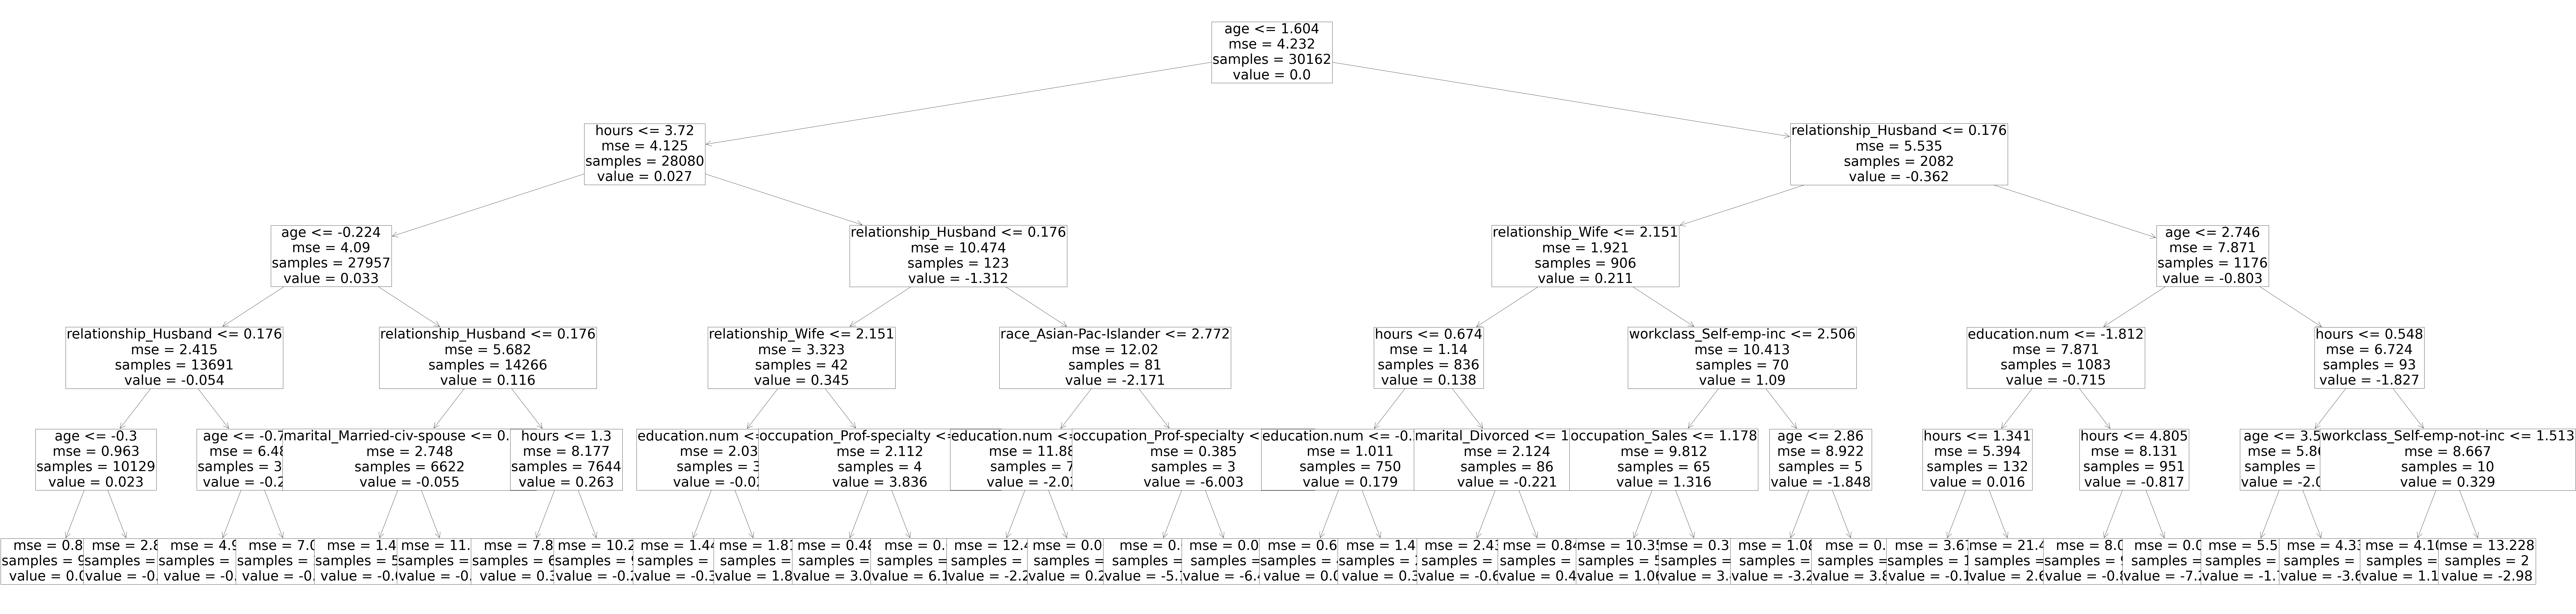

In [18]:
# Build a random forest regression model learnt on X to predict Y values
# where Y = calculated influences
# The idea is to identify attributes or predicates most important for influence computation
# print("Ground truth decision tree")
# norm_gt_spd = spdgt.copy()
# norm_gt_spd = [float(i)*10000/sum(norm_gt_spd) for i in norm_gt_spd]
# regr_2 = DecisionTreeRegressor(max_depth=5) 
# regr_2.fit(X_train, norm_gt_spd)
# plt.figure(figsize=(200,50))
# plot_tree(regr_2, feature_names=X_train_orig.columns, fontsize=60)
# plot_tree(regr_2, fontsize=60)

print("Influence functions decision tree")
norm_infs = infs_1.copy()
norm_infs = [float(i)/sum(norm_infs) for i in norm_infs]
regr_1 = DecisionTreeRegressor(max_depth=5) 
regr_1.fit(X_train, norm_infs)
plt.figure(figsize=(200,50))
plot_tree(regr_1, feature_names=X_train_orig.columns, fontsize=60)

**Fairness/Accuracy change removing predicates according to the regression tree**

In [19]:
df = pd.DataFrame(data=X_train, columns=X_train_orig.columns)
# idx = df[(df['hours']>-.453) & (df['age']>-.224) &(df['gender_Male']>-.375) &(df['age']<=1.299) &(df['hours']<=1.3)].index.tolist() 
idx = df[(df['age']<=1.604) & (df['hours']<=3.72) & (df['age']>0.224) & (df['relationship_Husband']>0.176) & (df['hours']<=1.3)].index.tolist() 
X_removed = np.delete(X_train, idx, 0)
y_removed = y_train.drop(index=idx, inplace=False)
clf.fit(X_removed, y_removed)
y_pred = clf.predict_proba(X_test)
spd = computeFairness(y_pred, X_test_orig)
print("Fraction of records: ", len(idx)/len(X_train))
print("Improvement in fairness: ", spd/spd_0 - 1)
loss = logistic_loss(y_test, y_pred)
print("Accuracy drop: ", loss/lloss - 1)

Fraction of records:  0.15313971222067502
Improvement in fairness:  -0.10994172910448308
Accuracy drop:  0.007885610754811534


**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [16]:
threshold = 0.0001
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

# for i in range(len(X_test)):
#     y_pred_test[i] = np.round(y_pred_test[i], 3)
#     y_pred_test[i] = np.round(y_pred_test[i], 3)

# for i in range(len(X_train)):
#     y_pred_train[i] = np.round(y_pred_train[i], 3)
#     y_pred_train[i] = np.round(y_pred_train[i], 3)
    
spd_0 = computeFairness(y_pred_test, X_test_orig)
print("Initial fairness: ", spd_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)
    
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

Initial fairness:  -0.20059371090978573
Initial loss:  0.360972684923813


**Compute: (1) First-order influence, (2) Ground truth influence of each training data point**

In [17]:
# Ground truth influence
# spdgt = ground_truth_influence(X_train, y_train, X_test, X_test_orig)
# with open('delta_spd_ground_truth_v0.txt', 'w') as filehandle:
#     for listitem in delta_spd:
#         filehandle.write('%s\n' % listitem)
gt_spd = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
gt_spd = gt_spd.values.tolist()
spdgt=[]
for i in range(len(gt_spd)):
    spdgt.append(gt_spd[i][0])
sort_index = np.argsort(spdgt)[::-1][:len(spdgt)]

In [18]:
size_hvp = int(len(X_train) * .12)
# Hessian vector product H^{-1}v, v = del_fairness
v = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
# v = del_L_del_theta[3]
hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v, hessian_all_points)

infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))
print("Spearman rank correlation between 1st order inf and ground truth inf: ", 
      stats.spearmanr(spdgt, infs_1)[0])
print("Pearson correlation coefficient between 1st order inf and ground truth inf: ", 
      stats.pearsonr(spdgt, infs_1)[0])

Spearman rank correlation between 1st order inf and ground truth inf:  0.9242478999043249
Pearson correlation coefficient between 1st order inf and ground truth inf:  0.8916486170302536


In [20]:
a = []
for i in range(len(infs_1)):
    a.insert(i, abs(infs_1[i]))
    
a = np.argsort(a)[::-1][:len(a)]
infs_500=[]
spdgt_500=[]
for i in range(500):
    infs_500.insert(i, infs_1[a[i]])
    spdgt_500.insert(i, spdgt[a[i]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


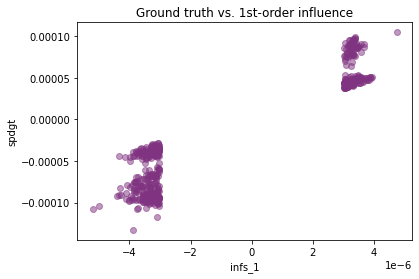

In [21]:
colors = (0.5,0.2,0.5)
# area = np.pi*3

# Plot
plt.scatter(infs_500, spdgt_500, c=colors, alpha=0.5)
plt.title('Ground truth vs. 1st-order influence')
plt.xlabel('infs_1')
plt.ylabel('spdgt')
plt.show()

**Checking ground truth, first-order and second-order influences for a set**

In [26]:
# ground truth predicates
predicates = ['marital_Married-civ-spouse']

# 1st-order influence predicates
predicates = ['occupation_Armed-Forces', 'relationship_Not-in-family', 'education.num', 'marital_Married-spouse-absent']
predicates = ['relationship_Not-in-family', 'occupation_Tech-support']
predicates = ['workclass_Private', 'occupation_Handlers-cleaners', 'race_Black', 'occupation_Other-service', 'marital_Divorced', 'race_Other', 'occupation_Protective-serv', 'relationship_Wife', 'occupation_Sales', 'relationship_Husband', 'hours', 'marital_Never-married', 'relationship_Own-child', 'marital_Married-spouse-absent', 'occupation_Exec-managerial', 'marital_Married-civ-spouse', 'occupation_Tech-support', 'race_Asian-Pac-Islander', 'occupation_Farming-fishing', 'marital_Married-AF-spouse', 'relationship_Other-relative', 'workclass_Self-emp-not-inc', 'marital_Separated', 'race_White', 'workclass_Federal-gov', 'marital_Widowed', 'occupation_Prof-specialty', 'relationship_Unmarried', 'education.num', 'workclass_State-gov', 'occupation_Transport-moving', 'gender_Male', 'workclass_Local-gov', 'occupation_Craft-repair', 'relationship_Not-in-family', 'occupation_Priv-house-serv']

idx = X_train_orig[(X_train_orig[predicates[0]] == 1)
#                    & (X_train_orig[predicates[1]] == 1) 
#                    & (X_train_orig[predicates[2]] == 1)
#                    & (X_train_orig[predicates[3]] == 1)
                  ].index 

print(len(idx))

X = np.delete(X_train, idx, 0)
y = y_train.drop(index=idx, inplace=False)
clf.fit(X, y)
y_pred_test = clf.predict_proba(X_test)
print("Ground truth influence: ", computeFairness(y_pred_test, X_test_orig) - spd_0)

del_f = 0
for i in range(len(idx)):
    del_f += infs_1[idx[i]]
print("First-order influence: ", del_f)

# print("Second-order influence: ", second_order_influence(X_train, hinv_v, idx, size_hvp, del_L_del_theta, hessian_all_points))

22286
Ground truth influence:  0.016080198794457323
First-order influence:  0.0001967901656447351


**Greedy heuristic for selecting attributes**

In [22]:
#method=1 (retrain), 2 (first-order), 3 (second-order)
def getInfluenceOfSet(indices, method, f, size, infs, v1, del_L_del_theta,
                      X_train, y_train, X_test, X_test_orig): 
    del_f = 0
    if (method == 1):
        X = np.delete(X_train, indices, 0)
        y = y_train.drop(index=indices, inplace=False)
        clf.fit(X, y)
        y_pred = clf.predict_proba(X_test)
        del_f = computeFairness(y_pred, X_test_orig) - f
    elif (method == 2):
        for i in range(len(indices)):
            del_f += infs[indices[i]]
    elif (method == 3):
        del_f = second_order_influence(X_train, v1, indices, size, del_L_del_theta, hessian_all_points)
    return del_f
        
def getAttribute(method, f, size, infs, attrList, v1, cols, del_L_del_theta,
                 X_train, y_train, X_train_orig, X_test, X_test_orig):
    attrK = None
    attrKval = None
    f_curr = f
    indices = []
    print(f_curr)
    cols = list(set(cols) - set(attrList))
    
    X_train_pred = copy.deepcopy(X_train_orig)
    for i in range(len(attrList)):
#         print(i)
        X_train_pred = X_train_orig[X_train_orig[attrList[i]] == 1]
    
    for col in cols:
        print("Attribute: ", col)
        indices = X_train_pred[X_train_pred[col] == 1].index      
        
        del_f = getInfluenceOfSet(indices, method, f_curr, size, infs, v1, del_L_del_theta,
                      X_train, y_train, X_test, X_test_orig)
        print("Influence of set: ", del_f)
        
        f_col = f_curr + del_f
        print("Del_f: ", del_f)
        print("f_col: ", f_col)
        
#         if ((del_f > 0) and (abs(f_col) > threshold) and (abs(f_col) < abs(f_curr))):
        if ((abs(f_col) > threshold) and (abs(f_col) < abs(f_curr))):
            attrK = col
            f_curr = f_col
            print("Attribute passed: ", attrK)
            print("f: ", f_curr)
    
    return [attrK, f_curr]

def getPredicates(method, f_0, size, infs, v1, del_L_del_theta,
                  X_train, y_train, X_train_orig, X_test, X_test_orig):    
    attrList = []
    found = True
    f_curr = f_0
    depth=0
    k = len(X_train_orig.columns)
    while (k > 0 and found):
        print("Depth: ", depth)
        depth += 1
        found = False
        results = getAttribute(method, f_curr, size, infs, attrList, v1, X_train_orig.columns,
                               del_L_del_theta, X_train, y_train, X_train_orig, X_test, X_test_orig)
    
        attrK = results[0]
        f = results[1]
        
        if (attrK is not None):
            attrList.insert(len(attrList), attrK)
            f_curr = f
            print("Selected k: ", attrK)
            print("f: ", f)
            found = True
            
    return attrList

In [23]:
# Get predicates on training data
# method = 1 (retrain), 2 (first-order), 3 (second-order)
method = 2
attrList = getPredicates(method, spd_0, size_hvp, infs_1, hinv_v, del_L_del_theta,
                 X_train, y_train, X_train_orig, X_test, X_test_orig)

print(attrList)

Depth:  0
-0.20059371090978573
Attribute:  occupation_Armed-Forces
Influence of set:  8.196010185146456e-07
Del_f:  8.196010185146456e-07
f_col:  -0.2005928913087672
Attribute passed:  occupation_Armed-Forces
f:  -0.2005928913087672
Attribute:  gender_Female
Influence of set:  1.808955618926223e-05
Del_f:  1.808955618926223e-05
f_col:  -0.20057480175257794
Attribute passed:  gender_Female
f:  -0.20057480175257794
Attribute:  workclass_Self-emp-inc
Influence of set:  6.723518706706959e-06
Del_f:  6.723518706706959e-06
f_col:  -0.20056807823387124
Attribute passed:  workclass_Self-emp-inc
f:  -0.20056807823387124
Attribute:  workclass_Local-gov
Influence of set:  2.699243849105216e-05
Del_f:  2.699243849105216e-05
f_col:  -0.2005410857953802
Attribute passed:  workclass_Local-gov
f:  -0.2005410857953802
Attribute:  gender_Male
Influence of set:  -1.7559605186128515e-05
Del_f:  -1.7559605186128515e-05
f_col:  -0.2005586454005663
Attribute:  occupation_Craft-repair
Influence of set:  -4.16

Influence of set:  -8.593493909543261e-06
Del_f:  -8.593493909543261e-06
f_col:  -0.19865819476541663
Attribute:  relationship_Wife
Influence of set:  5.3144783173406706e-05
Del_f:  5.3144783173406706e-05
f_col:  -0.19859645648833366
Attribute passed:  relationship_Wife
f:  -0.19859645648833366
Attribute:  occupation_Other-service
Influence of set:  -2.2335318593119407e-05
Del_f:  -2.2335318593119407e-05
f_col:  -0.19861879180692676
Attribute:  marital_Married-spouse-absent
Influence of set:  6.506142435803744e-07
Del_f:  6.506142435803744e-07
f_col:  -0.19859580587409006
Attribute passed:  marital_Married-spouse-absent
f:  -0.19859580587409006
Attribute:  race_Black
Influence of set:  9.366358022318516e-05
Del_f:  9.366358022318516e-05
f_col:  -0.19850214229386687
Attribute passed:  race_Black
f:  -0.19850214229386687
Attribute:  occupation_Handlers-cleaners
Influence of set:  8.131076511022995e-06
Del_f:  8.131076511022995e-06
f_col:  -0.19849401121735585
Attribute passed:  occupatio

Influence of set:  -1.359554889808011e-09
Del_f:  -1.359554889808011e-09
f_col:  -0.19789718355012187
Attribute:  relationship_Not-in-family
Influence of set:  1.7932797501605139e-06
Del_f:  1.7932797501605139e-06
f_col:  -0.19789538891081682
Attribute passed:  relationship_Not-in-family
f:  -0.19789538891081682
Attribute:  marital_Widowed
Influence of set:  -5.2979556814005555e-06
Del_f:  -5.2979556814005555e-06
f_col:  -0.19790068686649823
Attribute:  workclass_Federal-gov
Influence of set:  -4.7243849116327015e-06
Del_f:  -4.7243849116327015e-06
f_col:  -0.19790011329572846
Attribute:  education.num
Influence of set:  -1.5913500370317828e-07
Del_f:  -1.5913500370317828e-07
f_col:  -0.19789554804582052
Attribute:  marital_Separated
Influence of set:  1.3677249675878338e-06
Del_f:  1.3677249675878338e-06
f_col:  -0.19789402118584923
Attribute passed:  marital_Separated
f:  -0.19789402118584923
Attribute:  occupation_Exec-managerial
Influence of set:  0
Del_f:  0
f_col:  -0.19789402118

f:  -0.19755523284316015
Selected k:  occupation_Protective-serv
f:  -0.19755523284316015
Depth:  7
-0.19755523284316015
Attribute:  occupation_Armed-Forces
Influence of set:  0
Del_f:  0
f_col:  -0.19755523284316015
Attribute:  gender_Female
Influence of set:  -7.691362176426012e-06
Del_f:  -7.691362176426012e-06
f_col:  -0.19756292420533658
Attribute:  workclass_Self-emp-inc
Influence of set:  -1.9748406863194607e-06
Del_f:  -1.9748406863194607e-06
f_col:  -0.19755720768384646
Attribute:  workclass_Local-gov
Influence of set:  7.401219838369956e-05
Del_f:  7.401219838369956e-05
f_col:  -0.19748122064477644
Attribute passed:  workclass_Local-gov
f:  -0.19748122064477644
Attribute:  gender_Male
Influence of set:  -1.2747865424126838e-05
Del_f:  -1.2747865424126838e-05
f_col:  -0.19749396851020057
Attribute:  occupation_Craft-repair
Influence of set:  0
Del_f:  0
f_col:  -0.19748122064477644
Attribute:  occupation_Transport-moving
Influence of set:  0
Del_f:  0
f_col:  -0.19748122064477

Influence of set:  5.465714949369596e-06
Del_f:  5.465714949369596e-06
f_col:  -0.1972165962977665
Attribute passed:  marital_Separated
f:  -0.1972165962977665
Attribute:  occupation_Exec-managerial
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  occupation_Prof-specialty
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  occupation_Farming-fishing
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  race_White
Influence of set:  8.523127818822061e-05
Del_f:  8.523127818822061e-05
f_col:  -0.1971313650195783
Attribute passed:  race_White
f:  -0.1971313650195783
Attribute:  relationship_Other-relative
Influence of set:  -1.7378348367210434e-06
Del_f:  -1.7378348367210434e-06
f_col:  -0.19713310285441502
Attribute:  workclass_Self-emp-not-inc
Influence of set:  -2.7127479304370597e-05
Del_f:  -2.7127479304370597e-05
f_col:  -0.19715849249888265
Attribute:  marital_Married-civ-spouse
Influence of set:  6.593687562910461e-05
Del_

Attribute:  occupation_Armed-Forces
Influence of set:  -5.489094260036159e-09
Del_f:  -5.489094260036159e-09
f_col:  -0.1967876266700323
Attribute:  gender_Female
Influence of set:  -1.0996207631770658e-05
Del_f:  -1.0996207631770658e-05
f_col:  -0.1967986173885698
Attribute:  workclass_Self-emp-inc
Influence of set:  1.1046490182483104e-06
Del_f:  1.1046490182483104e-06
f_col:  -0.19678651653191978
Attribute passed:  workclass_Self-emp-inc
f:  -0.19678651653191978
Attribute:  workclass_Local-gov
Influence of set:  -8.350393986959547e-07
Del_f:  -8.350393986959547e-07
f_col:  -0.19678735157131846
Attribute:  gender_Male
Influence of set:  5.845721838606087e-06
Del_f:  5.845721838606087e-06
f_col:  -0.1967806708100812
Attribute passed:  gender_Male
f:  -0.1967806708100812
Attribute:  occupation_Craft-repair
Influence of set:  3.2612884129131747e-06
Del_f:  3.2612884129131747e-06
f_col:  -0.19677740952166828
Attribute passed:  occupation_Craft-repair
f:  -0.19677740952166828
Attribute:  

Influence of set:  -8.999777925324406e-07
Del_f:  -8.999777925324406e-07
f_col:  -0.19673147017627696
Attribute:  age
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  occupation_Adm-clerical
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  race_Amer-Indian-Eskimo
Influence of set:  -1.0259679513184373e-05
Del_f:  -1.0259679513184373e-05
f_col:  -0.1967408298779976
Attribute:  occupation_Machine-op-inspct
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  workclass_Without-pay
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  relationship_Not-in-family
Influence of set:  -5.400075701666e-05
Del_f:  -5.400075701666e-05
f_col:  -0.1967845709555011
Attribute:  marital_Widowed
Influence of set:  7.429703599987473e-06
Del_f:  7.429703599987473e-06
f_col:  -0.19672314049488443
Attribute passed:  marital_Widowed
f:  -0.19672314049488443
Attribute:  workclass_Federal-gov
Influence of set:  2.045542183655450

Influence of set:  -5.366635308134836e-06
Del_f:  -5.366635308134836e-06
f_col:  -0.1964023540048403
Attribute:  relationship_Other-relative
Influence of set:  1.0658920664334734e-07
Del_f:  1.0658920664334734e-07
f_col:  -0.1963968807803255
Attribute passed:  relationship_Other-relative
f:  -0.1963968807803255
Attribute:  workclass_Self-emp-not-inc
Influence of set:  -1.4709523317961235e-06
Del_f:  -1.4709523317961235e-06
f_col:  -0.1963983517326573
Selected k:  relationship_Other-relative
f:  -0.1963968807803255
Depth:  21
-0.1963968807803255
Attribute:  occupation_Armed-Forces
Influence of set:  -1.5934443973975213e-07
Del_f:  -1.5934443973975213e-07
f_col:  -0.19639704012476522
Attribute:  gender_Female
Influence of set:  -3.8102575104908755e-06
Del_f:  -3.8102575104908755e-06
f_col:  -0.19640069103783597
Attribute:  workclass_Self-emp-inc
Influence of set:  8.226312648939984e-07
Del_f:  8.226312648939984e-07
f_col:  -0.1963960581490606
Attribute passed:  workclass_Self-emp-inc
f: 

Attribute:  occupation_Armed-Forces
Influence of set:  8.196010185146456e-07
Del_f:  8.196010185146456e-07
f_col:  -0.19601460375099689
Attribute passed:  occupation_Armed-Forces
f:  -0.19601460375099689
Attribute:  gender_Female
Influence of set:  1.3526868387633927e-05
Del_f:  1.3526868387633927e-05
f_col:  -0.19600107688260926
Attribute passed:  gender_Female
f:  -0.19600107688260926
Attribute:  workclass_Self-emp-inc
Influence of set:  0
Del_f:  0
f_col:  -0.19600107688260926
Attribute:  workclass_Local-gov
Influence of set:  0
Del_f:  0
f_col:  -0.19600107688260926
Attribute:  gender_Male
Influence of set:  2.5731685993551943e-05
Del_f:  2.5731685993551943e-05
f_col:  -0.19597534519661572
Attribute passed:  gender_Male
f:  -0.19597534519661572
Attribute:  occupation_Craft-repair
Influence of set:  -1.3996678784421155e-05
Del_f:  -1.3996678784421155e-05
f_col:  -0.19598934187540015
Attribute:  occupation_Transport-moving
Influence of set:  -3.463662861933257e-06
Del_f:  -3.46366286

Attribute:  occupation_Adm-clerical
Influence of set:  1.3770791097848645e-09
Del_f:  1.3770791097848645e-09
f_col:  -0.19558285093253433
Attribute passed:  occupation_Adm-clerical
f:  -0.19558285093253433
Attribute:  occupation_Armed-Forces
Influence of set:  0
Del_f:  0
f_col:  -0.19558285093253433
Attribute:  race_Amer-Indian-Eskimo
Influence of set:  0
Del_f:  0
f_col:  -0.19558285093253433
Attribute:  occupation_Machine-op-inspct
Influence of set:  5.163756760462376e-08
Del_f:  5.163756760462376e-08
f_col:  -0.19558279929496672
Attribute passed:  occupation_Machine-op-inspct
f:  -0.19558279929496672
Attribute:  workclass_Without-pay
Influence of set:  0
Del_f:  0
f_col:  -0.19558279929496672
Attribute:  gender_Female
Influence of set:  3.244198975674469e-07
Del_f:  3.244198975674469e-07
f_col:  -0.19558247487506916
Attribute passed:  gender_Female
f:  -0.19558247487506916
Attribute:  relationship_Not-in-family
Influence of set:  -2.2516248516006355e-08
Del_f:  -2.2516248516006355e